**Descarga y Descompreción del Dataset a Utilizar**

**Visualización de Imagenes de las 2 Categorías a Clasificar**

In [ ]:
# !pip install matplotlib
# !pip install skimage
# !conda install -c anaconda scikit-image

---
**Definición de una RN de ejemplo con 1 Neurona para Imágenes de 180x180 píxels**

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
#from tensorflow.keras.applications.inception_v3 import InceptionV3

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten  , Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from sklearn.metrics import accuracy_score

# Definicion del modelo

## Carga del modelo

In [ ]:
config1={'include_top':False,'minimalistic':'True'}

config=config1

In [ ]:
# constantes para arquitectura, generación datos y entrenamiento/validacion
IMG_SIZE = (180, 180, 3)  # tamaño de la imagen de entrada
N_CLASSES = 1          # cantidad de clases a identificar
LOTES = 128             # tamaño de lotes para entrenamiento y testeo 
ALFA = 0.001             # tasa de entrenamiento
EPOCAS = 1000           # cantidad de epocas a entrenar como máximo
PACIENCIA = 15          # parámetro para parada temprana

# %% construye le modelo
# obtiene la arquitectura para el modelo pre-entrenado
feature_model = MobileNetV3Small(
    input_shape=IMG_SIZE,
    minimalistic=config['minimalistic'],
    include_top=config['include_top'],
    weights="imagenet",
    include_preprocessing=True,
)

In [ ]:
# feature_model.summary()

## Agregado de capas

In [ ]:
# construye el modelo de manera funcional

layers = Flatten() (feature_model.output)
# layers = Flatten() (feature_model.get_layer("Logits").output)
layers = Dense(32, activation="LeakyReLU")(layers)
layers = BatchNormalization()(layers)
layers = Dense(16, activation="LeakyReLU")(layers)
layers = BatchNormalization()(layers)
layers = Dropout(0.2)(layers)
output = Dense(N_CLASSES, activation='sigmoid')(layers)

model = Model(inputs=feature_model.input, outputs=output)

# The newly added layers are initialized with random values.
# Make sure based model remain unchanged until newly added layers weights get reasonable values.

for layer in feature_model.layers:
    layer.trainable = False


# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PACIENCIA,  
                           restore_best_weights=True)
    
#Optimizer
opt = Adam(learning_rate=ALFA)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

print("Cantidad de parametros "+str(model.count_params()))

Cantidad de parametros 1065385


In [ ]:
# model.summary()

# Carga de datos

In [ ]:
new_base_dir='./manga_comic'
new_base_dir_clear='./manga_comic_clear'
FUENTES_DIR='./Fuentes'

In [ ]:
IMG_SIZE = (180, 180)
TAM_LOTE = 32
SUFFLE=True

train_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"train",
    shuffle=SUFFLE,
    seed=2016,
    image_size=IMG_SIZE,
    batch_size=TAM_LOTE)

validation_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"validation",
    shuffle=SUFFLE,
    seed=2016,    
    image_size=IMG_SIZE,
    batch_size=TAM_LOTE)

test_dataset = image_dataset_from_directory(
    new_base_dir+"/"+"test",
    shuffle=SUFFLE,
    seed=2016,    
    image_size=IMG_SIZE,
    batch_size=TAM_LOTE)

Found 3942 files belonging to 2 classes.
Found 1990 files belonging to 2 classes.
Found 2649 files belonging to 2 classes.


In [ ]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        all_features.append(images)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

# Data Augmentation

In [ ]:
data_augmentation=True

datagen = ImageDataGenerator(
#     rescale=1/255.,
    width_shift_range=[-50,50],
#     height_shift_range=[-20,20],
    zoom_range=[0.75,1.25],
    vertical_flip=True,
    fill_mode="reflect",#"reflect","nearest","constant"
    cval=255.0
)

training_generator = datagen.flow(train_features, train_labels, batch_size=LOTES,seed=7)
validation_generator = datagen.flow(val_features, val_labels, batch_size=LOTES,seed=7)

# Entrenamiento

In [ ]:
H=None

if data_augmentation:
    H = model.fit_generator(generator=training_generator,validation_data =validation_generator, 
                  epochs=EPOCAS, callbacks=[early_stop],verbose=True)    
else:
    H = model.fit(
    #     train_dataset,validation_data=validation_dataset,
        x = train_features,y=train_labels,validation_data =(val_features,val_labels),
        validation_steps= 16,
        epochs=EPOCAS,
        callbacks=[early_stop])

C:\Users\u500246\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/1000
31/31 [==============================] - 84s 3s/step - loss: 0.4697 - accuracy: 0.7803 - val_loss: 0.3576 - val_accuracy: 0.8472
Epoch 2/1000
31/31 [==============================] - 77s 2s/step - loss: 0.3641 - accuracy: 0.8496 - val_loss: 0.3584 - val_accuracy: 0.8392
Epoch 3/1000
31/31 [==============================] - 75s 2s/step - loss: 0.3340 - accuracy: 0.8574 - val_loss: 0.3564 - val_accuracy: 0.8387
Epoch 4/1000
31/31 [==============================] - 72s 2s/step - loss: 0.3238 - accuracy: 0.8600 - val_loss: 0.3495 - val_accuracy: 0.8503
Epoch 5/1000
31/31 [==============================] - 72s 2s/step - loss: 0.3283 - accuracy: 0.8623 - val_loss: 0.3352 - val_accuracy: 0.8538
Epoch 6/1000
31/31 [==============================] - 72s 2s/step - loss: 0.3049 - accuracy: 0.8721 - val_loss: 0.3399 - val_accuracy: 0.8568
Epoch 7/1000
31/31 [==============================] - 73s 2s/step - loss: 0.3088 - accuracy: 0.8658 - val_loss: 0.3340 - val_accuracy: 0.8523
Epoch 

# Visualizacion y Conclusiones

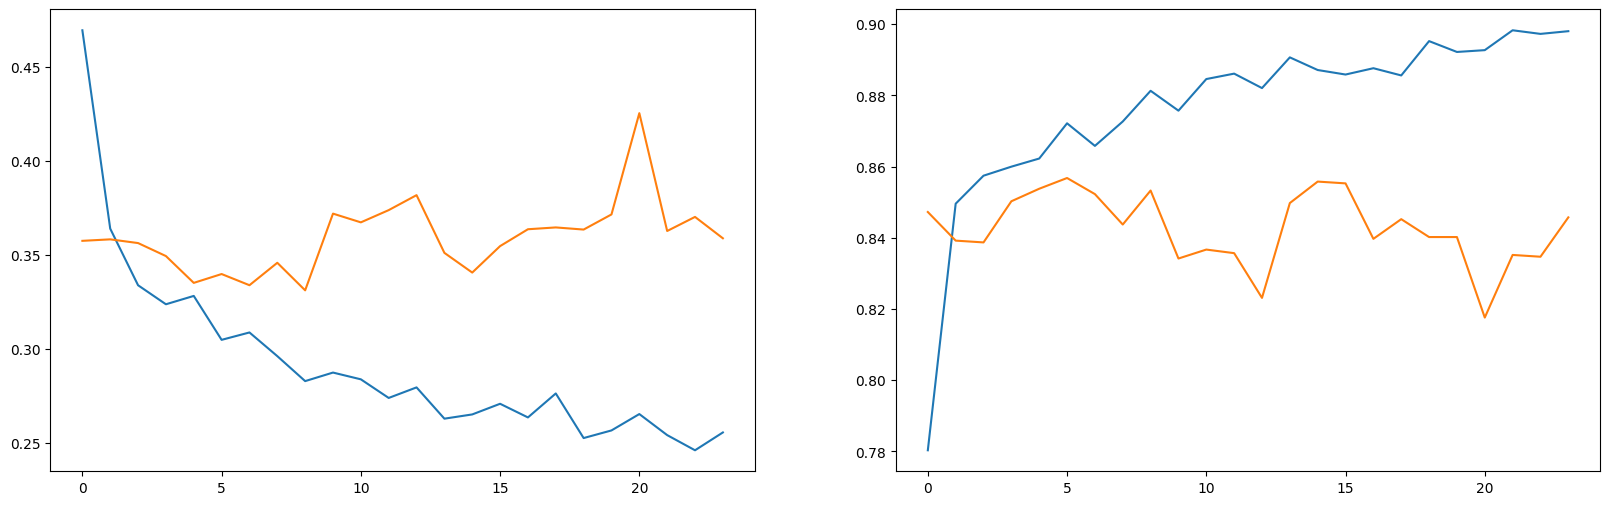

<Figure size 640x480 with 0 Axes>

In [ ]:
# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

# Resultados Test

In [ ]:
train_predictions = model.predict(train_features)
train_accuracy=accuracy_score(train_labels, train_predictions > 0.5)
print("Accuracy Test: "+str(train_accuracy))

Accuracy Test: 0.898021308980213


In [ ]:
val_predictions = model.predict(val_features)
val_accuracy=accuracy_score(val_labels, val_predictions > 0.5)
print("Accuracy Test: "+str(val_accuracy))

Accuracy Test: 0.8603015075376884


In [ ]:
test_predictions = model.predict(test_features)
test_accuracy=accuracy_score(test_labels, test_predictions > 0.5)
print("Accuracy Test: "+str(test_accuracy))

Accuracy Test: 0.8712721781804454


In [ ]:
model.save('modelo_entrega_v1.h5')

C:\Users\u500246\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
